# <center>Rayleigh Equation - Solução numérica</center>

Equação a ser resolvida é um clássico problema de autovalor, onde $\phi$ é o autovetor e $c$ é o autovalor da Equação de Rayleigh (considerando plano f) ou Rayleigh-Kuo (considerando plano $\beta$):

\begin{equation}
\frac{d^{2}\phi}{dy^{2}} -k^{2}\phi + \frac{ \frac{d\bar{q}}{dy} }{\bar{u} - c}\phi = 0
\end{equation}

onde: 
$\frac{d\bar{q}}{dy} = \beta - \frac{d^2\bar{u}}{dy^2}$ é o gradiente de vorticidade potencial básico do jato $\bar{u}(y)$

Convertendo RK_lista2.m de matlab para python e, no processo, respondendo o exercício 2.E da lista 2 de DFGII.

Links úteis:

. Eigenvalue and eigenvector problem:
    
[Mathematical Theory][1]
    
[Numerical Solution Using Jacobi's Method][2]
    
[1]: https://www.respondeai.com.br/resumos/33/capitulos/1
[2]: http://www.southampton.ac.uk/~feeg6002/lecturenotes/feeg6002_numerical_methods08.html
       


. https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html



In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

try:
    %matplotlib inline
except:
    # not in notebook
    pass
LECTURE = True
if LECTURE:
    size = 20
    matplotlib.rcParams['figure.figsize'] = (10, 4)
    matplotlib.rcParams['axes.labelsize'] = size 
    matplotlib.rcParams['axes.titlesize'] = size
    matplotlib.rcParams['xtick.labelsize'] = size * 0.4
    matplotlib.rcParams['ytick.labelsize'] = size * 0.4

In [3]:
### SET GLOBAL VARIABLES
lat = 30
# set beta = 0 for f-plane
beta = (2 * 7.29e-5 * math.cos(lat * np.pi/180))/6371e3

L  = 200e3 # 1/2 domain
dy = 2e3
y  = np.arange(-L, L, dy)
ny = len(y)

# jet profile
L0 = 50e3
U0 = 0.085
U  = np.asarray([U0 * 1/math.cosh(Y/L0)**2 for Y in y])
Uy = np.gradient(U, dy)
Uyy= np.gradient(Uy, dy)

Qy = beta - Uyy

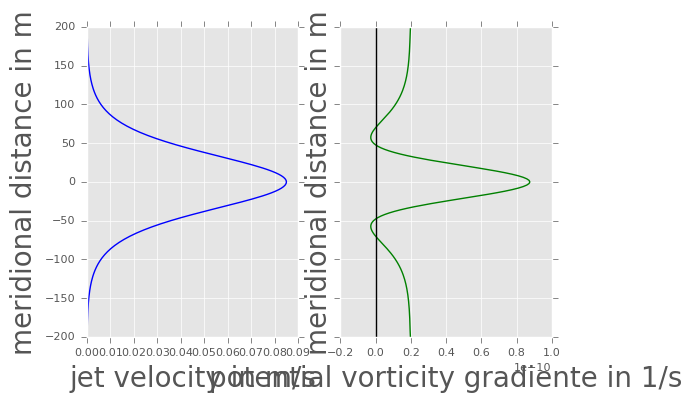

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

ax1.plot(U, 1e-3*y, 'b')
ax1.set_xlabel('jet velocity in m/s')
ax1.set_ylabel('meridional distance in m')

ax2.plot(Qy, 1e-3*y, 'g')
ax2.axvline(0, color='black')
ax2.set_xlabel('potential vorticity gradiente in 1/s')
ax2.set_ylabel('meridional distance in m')

# The Eigenvalue problem


## Solução analítica - teoria

Podemos resolver o problema de autovalor da seguinte forma. Se existir $\vec{v} \neq 0$, de forma que:

\begin{equation}
A \vec{v} = \lambda \vec{v}
\end{equation}

então:

\begin{equation}
(A - \lambda I)\vec{v} = 0
\end{equation}

Sendo A a matriz de dados, $\vec{v}$ o autovetor de A, $\lambda$ o autovalor associado e I a matriz identidade.

A equação acima deve ser válida para cada par de autovalor/autovetor. Como consideramos $\vec{v} \neq 0$, a equação só terá solução e e somente se:

\begin{equation}
\det{(A - \lambda I)} = 0
\end{equation}

O cálculo do determinante nos conduzirá a uma equação polinomial de ordem n, denominada polinômio característico, cuja solução serão o conjunto de autovalores da matriz A.

Desta forma, para cada valor de $\lambda$ encontrado no conjunto, obtemos um autovetor ao resolver $(A - \lambda I)\vec{v}= 0$. 

O espaço-solução de autovetores é chamado de autoespaço, enquanto que o conjunto de autovalores é chamado de espectro.

## Compreensão do algoritmo RK_solver_lista2.m e Solução Numérica para o problema

Problema:
    \begin{equation}
    (A-Bc)P = 0
    \end{equation}



        A - matriz de dados
        B - matriz identidade
        c - autovalor associado
        P - autovetor de A

    A e B são matrizes tridiagonais, ou seja, matrizes em que os elementos
    não nulos são da diagonal principal e 1 diagonal acima e 1 abaixo da diagonal
    principal:

\\begin{equation}
 A =
\begin{pmatrix}
  a_{1} & b_{1} &  0    & ... & 0\\\\
  c_{1} & a_{2} & b_{2} & ... & 0\\\\
    ...   & c_{2} & a_{3} & b_{n-1} & 0\\\\
    ...   &   0   & c_{3} & a_{n} & b_{n}
\end{pmatrix}
\end{equation}


Definição de algumas variáveis:
    
    . k   - número de ondas em 1/km
    . nk  - comprimento de k

criar matrizes que armazenarão os dados de:

    . cr  - velocidade de fase (real)
    . sig - taxa de crescimento, dada por $\sigma = k ci$, sendo ci a parte imaginária de c
    . P   - modos instáveis ou o autovetor da matriz de dados



In [5]:
# wavenumbers in 1/km
k = np.asarray(np.arange(0.04, 0.002, -0.001)) * 1e-3
nk = len(k)

# initialize the phase speed (cr), growth rate (sig from sigma) and unstable modes (P) matrices
cr = np.zeros(nk)
sig = cr
P = np.zeros([ny,nk])

In [13]:
for n in range(0,nk,1): # wavenumber loop

    # setting up the matrix coefficients
    L1 = 1/dy/dy
    L2 = 2/dy/dy + k[n]*k[n]
    L3 = L1

    # building tridiagonal matrices A and B
    A = np.diag(Qy - L2 * U) + np.diag( L3 * U[1:ny],1) + np.diag(L1*U[1:ny] ,-1)
    B = np.diag(-L2 * np.squeeze(np.ones([1,ny]))) + np.diag(L3*np.squeeze(np.ones([1,ny-1])), 1) + np.diag(L1*np.squeeze(np.ones([1,ny-1])), -1)
    # obtaining the eigenvalue matrix
    C = np.linalg.solve(B, A)

    # calculate eigenvalues and eigenvector for k[n]
    F,lamb  = np.linalg.eig(C)
    w = np.diag(lamb) # create matrix [ny,ny]
    ci = np.nanmax(np.diag(np.imag(w)))

    if ci != 0:
        print(ci)

    # if ci == 0:
    #     sig[n] = 0
    #     cr[n]  = np.nan
    #     P[:,n] = np.nan*np.ones([ny])
    # else:
    #     sig[n] = k[n]*ci*86400          # growth rate in 1/days
    #     cr[n]  = np.real(w[jmax,jmax])  # phase speed in m/s
    #     P[:,n] = F[:, jmax]             # meridional mode structure

